In [26]:
import os
import shutil
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

# --- TRANSFORMS ---
# --- TRANSFORMS ---
transform_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- MNIST TRAINING DATA ---
trainset = datasets.MNIST(
    root='./MNIST_data',
    train=True,
    download=True,
    transform=transform_train
)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# --- ORGANIZE CUSTOM IMAGES BASED ON FILENAMES ---
custom_dir = './handpicked'

for filename in os.listdir(custom_dir):
    if filename.endswith('.png') and '-' in filename:
        label = filename.split('-')[0]  # e.g., '5-xxx.png' → '5'
        label_dir = os.path.join(custom_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.move(os.path.join(custom_dir, filename), os.path.join(label_dir, filename))

# --- CUSTOM GRAYSCALE IMAGE LOADER ---
def grayscale_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert("L")  # force grayscale

# --- CUSTOM HANDWRITTEN TEST DATASET ---
testset = ImageFolder(
    root=custom_dir,
    transform=transform_test,
    loader=grayscale_loader
)
testloader_custom = DataLoader(testset, batch_size=1, shuffle=False)

print("✅ MNIST training set and custom test set are ready.")


✅ MNIST training set and custom test set are ready.


In [27]:
from torch import nn

model = nn.Sequential(
    nn.Flatten(),               # [B, 1, 28, 28] → [B, 784]
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)


In [28]:
import torch
import matplotlib.pyplot as plt
from torch import nn

# Optional: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Track metrics
train_loss_history = []
val_acc_history = []

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    train_loss_history.append(avg_loss)

    # --- Validation on handwritten test set ---
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader_custom:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f} - Handwritten Accuracy: {val_acc:.2f}%")


Epoch 1/10 - Train Loss: 0.5758 - Handwritten Accuracy: 48.19%
Epoch 2/10 - Train Loss: 0.2498 - Handwritten Accuracy: 51.20%
Epoch 3/10 - Train Loss: 0.2054 - Handwritten Accuracy: 51.20%
Epoch 4/10 - Train Loss: 0.1747 - Handwritten Accuracy: 48.80%
Epoch 5/10 - Train Loss: 0.1564 - Handwritten Accuracy: 50.60%
Epoch 6/10 - Train Loss: 0.1422 - Handwritten Accuracy: 49.40%
Epoch 7/10 - Train Loss: 0.1374 - Handwritten Accuracy: 58.43%
Epoch 8/10 - Train Loss: 0.1246 - Handwritten Accuracy: 53.01%
Epoch 9/10 - Train Loss: 0.1206 - Handwritten Accuracy: 52.41%
Epoch 10/10 - Train Loss: 0.1140 - Handwritten Accuracy: 60.24%


In [32]:
# --- 7. Evaluation Function ---

def evaluate_model(model, dataloader, description="Test Set"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"\n✅ Accuracy on {description}: {accuracy:.2f}%")

# Example usage:
evaluate_model(model, testloader, "Custom Handwritten Digits")
# Or:
# evaluate_model(model, mnist_testloader, "MNIST Test Set")



✅ Accuracy on Custom Handwritten Digits: 48.63%


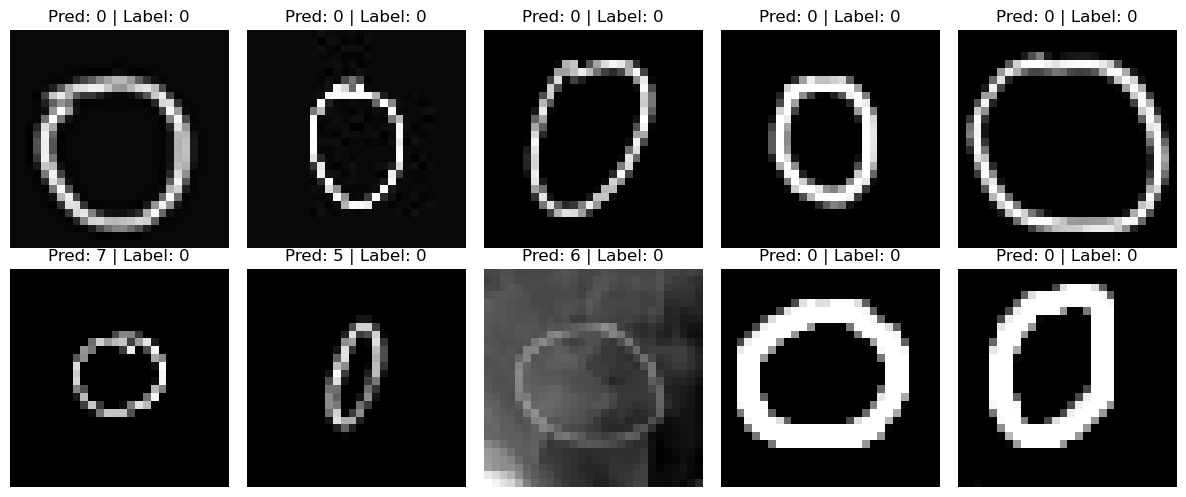

In [33]:
def show_mnist_predictions(model, testloader, num_images=10):
    model.eval()

    # Collect enough images for the grid
    images_list = []
    labels_list = []
    preds_list = []

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images.to(next(model.parameters()).device))
            _, preds = torch.max(outputs, 1)

            images_list.extend(images.cpu())
            labels_list.extend(labels.cpu())
            preds_list.extend(preds.cpu())

            if len(images_list) >= num_images:
                break

    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axs.flat):
        img = images_list[i][0]  # [C, H, W] → [H, W]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Pred: {preds_list[i].item()} | Label: {labels_list[i].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show predictions on custom handwritten digits
show_mnist_predictions(model, testloader)


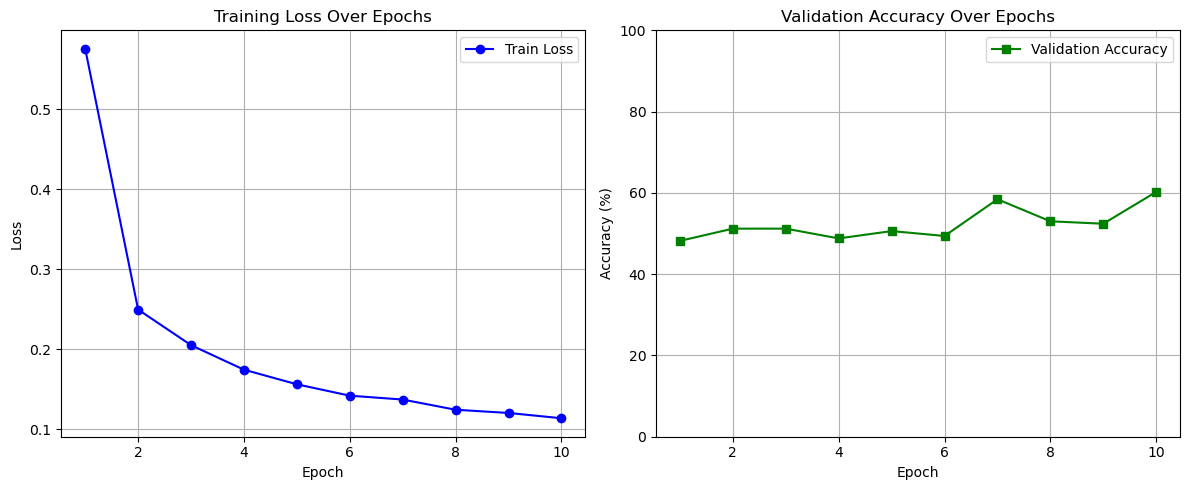

In [34]:
plt.figure(figsize=(12, 5))

# --- Training Loss ---
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_history, marker='o', label='Train Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# --- Validation Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_acc_history, marker='s', color='green', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # optional: clamp y-axis to 0–100%
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
